In [2]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords 
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer,PorterStemmer,LancasterStemmer
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer



import re
import unicodedata
import string 
from bs4 import BeautifulSoup
import itertools


from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import  RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,accuracy_score , classification_report,roc_curve,roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec , Phrases
from gensim.models import word2vec
from keras.models import Sequential 
from keras.layers import Dense , LSTM,Dropout, Bidirectional , Embedding 
from keras_preprocessing.sequence import pad_sequences


import os

In [4]:
path = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

imbd_data = pd.read_csv(path)

print(imbd_data.shape)


(50000, 2)


In [5]:
print(imbd_data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [6]:
imbd_data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
imbd_data['sentiment'].value_counts()
#Equal distrubution of both positive and negative review

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

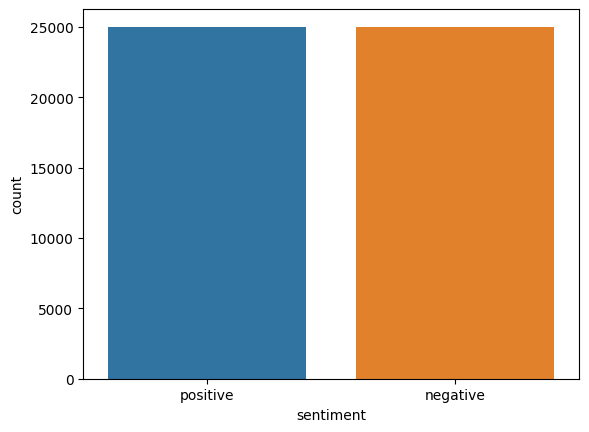

In [8]:
sns.countplot(x = "sentiment" , data = imbd_data)
plt.show()

    Presence of HTML Tags
0                       1
1                       1
2                       1
3                       1
4                       1
5                       0
6                       0
7                       1
8                       1
9                       1
10                      1
11                      1
12                      1
13                      1
14                      0
15                      0
16                      0
17                      1
18                      0
19                      0
20                      1
21                      1
22                      0
23                      1
24                      1
25                      1
26                      1
27                      1
28                      0
29                      1
30                      1
31                      1
32                      0
33                      1
34                      0
35                      1
36                      0
37          

<Axes: xlabel='Presence of HTML Tags', ylabel='Presence of HTML Tags'>

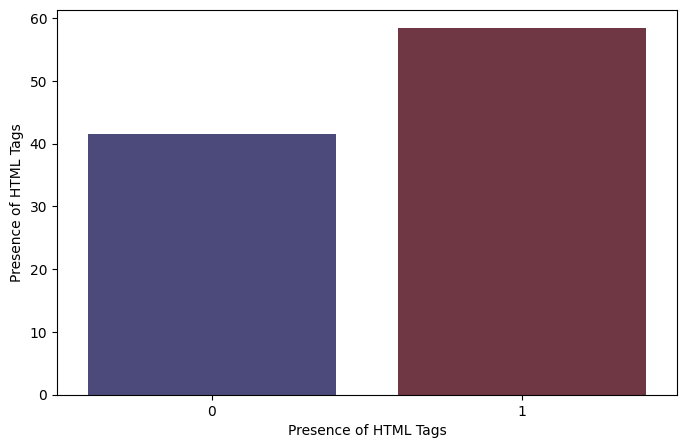

In [9]:
has_tag=[1 if re.search(r'<[^>]+>',text) else 0 for text in imbd_data['review']]


tag_df = pd.DataFrame({'Presence of HTML Tags' : has_tag})
print(tag_df.head(40))

plt.figure(figsize = (8,5))

sns.barplot(
    data=tag_df,
    x= "Presence of HTML Tags",
    y = "Presence of HTML Tags",
    estimator = lambda x :len(x) / len(tag_df)*100,
    palette ='icefire'
)

       Presence of Punctuations
0                             1
1                             1
2                             1
3                             1
4                             1
...                         ...
49995                         1
49996                         1
49997                         1
49998                         1
49999                         1

[50000 rows x 1 columns]


<Axes: xlabel='Presence of Punctuations', ylabel='Presence of Punctuations'>

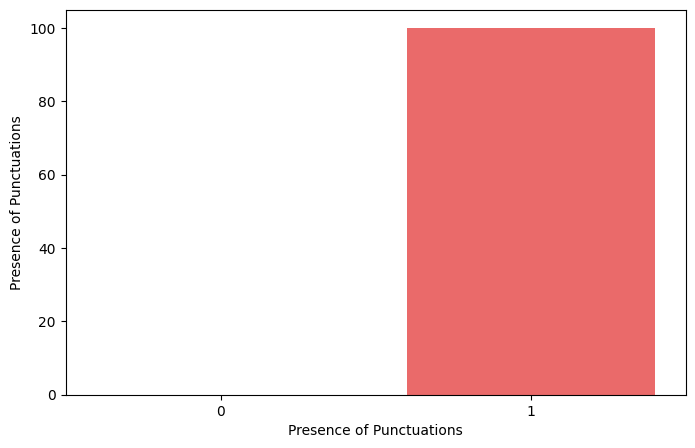

In [10]:
has_punc = [1 if re.search(r'[^\w\s]' , text) else 0 for text in imbd_data['review']]
punctuation_df = pd.DataFrame({"Presence of Punctuations" : has_punc})
print(punctuation_df)
plt.figure(figsize=(8,5))

sns.barplot(
    data=punctuation_df,
    x= "Presence of Punctuations",
    y = "Presence of Punctuations",
    estimator = lambda x :len(x) / len(punctuation_df)*100,
    palette ='seismic'
)

       Presence of URL
0                    0
1                    0
2                    0
3                    0
4                    0
...                ...
49995                0
49996                0
49997                0
49998                0
49999                0

[50000 rows x 1 columns]


<Axes: xlabel='Presence of URL', ylabel='Presence of URL'>

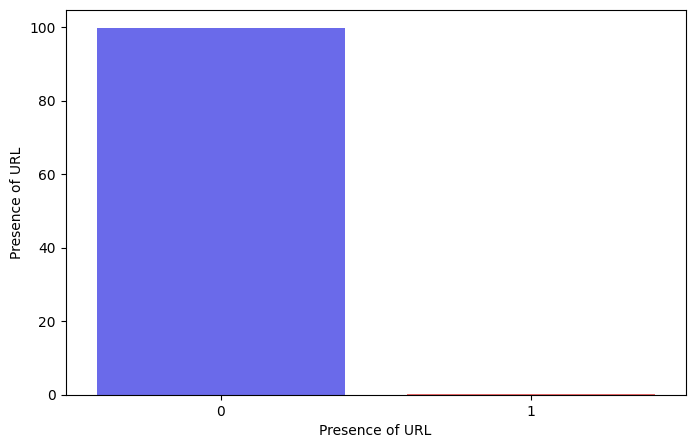

In [11]:
has_url = [1 if re.search(r'https?://\S+|www\.S+' , text) else 0 for text in imbd_data['review']]
url_df = pd.DataFrame({'Presence of URL' : has_url})

print(url_df)
plt.figure(figsize=(8,5))

sns.barplot(
    data=url_df,
    x= "Presence of URL",
    y = "Presence of URL",
    estimator = lambda x :len(x) / len(url_df)*100,
    palette ='seismic'
)


In [12]:
#Extracting features from the comments 

def feature_extractions(text):
    word_count =  len(text.split())
    numeric_count = len(re.findall(r'\d',text))
    
    mentions = 1 if re.search(r'@\w+',text) else 0
    
    uppercase_count = sum(1 for c in text if c.isupper())
    
    return word_count , numeric_count , mentions , uppercase_count





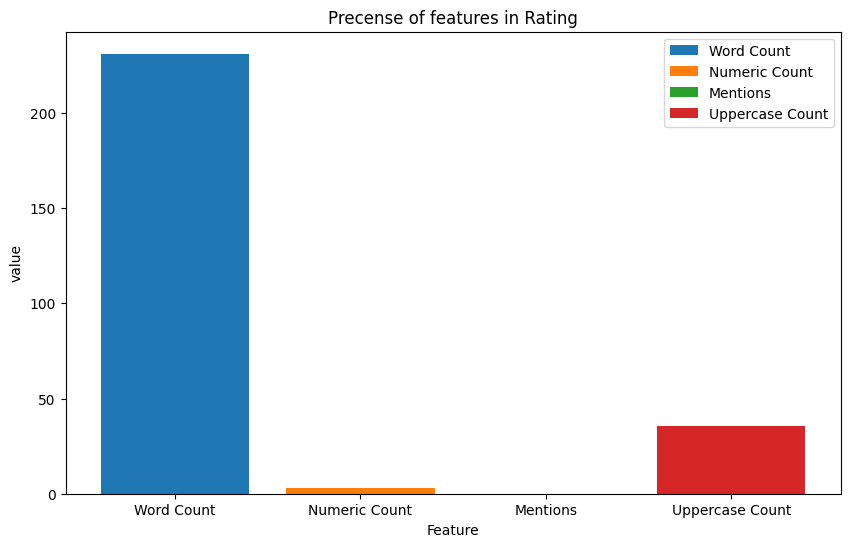

In [13]:
imbd_data['Word Count'] , imbd_data['Numeric Count'] ,imbd_data['Mentions'] , imbd_data['Uppercase Count'] = zip(*imbd_data['review'].apply(feature_extractions))
feature_to_plot = ['Word Count','Numeric Count','Mentions','Uppercase Count'] 
plt.figure(figsize = (10,6))
for feature in feature_to_plot:
    plt.bar(feature , imbd_data[feature].mean(),label = feature)

plt.title("Precense of features in Rating")
plt.xlabel("Feature")
plt.ylabel("value")
plt.legend()


In [14]:
review_positive = imbd_data[imbd_data['sentiment'] == 'positive']
review_negative = imbd_data[imbd_data['sentiment'] == 'negative']

In [15]:
review_positive.head()

,review,sentiment,Word Count,Numeric Count,Mentions,Uppercase Count
0,One of the other reviewers has mentioned that ...,positive,307,1,0,43
1,A wonderful little production. <br /><br />The...,positive,162,0,0,16
2,I thought this was a wonderful way to spend ti...,positive,166,1,0,23
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,0,0,34
5,"Probably my all-time favorite movie, a story o...",positive,119,4,0,10


In [16]:
review_negative.head()

,review,sentiment,Word Count,Numeric Count,Mentions,Uppercase Count
3,Basically there's a family where a little boy ...,negative,138,3,0,24
7,"This show was an amazing, fresh & innovative i...",negative,174,9,0,11
8,Encouraged by the positive comments about this...,negative,130,4,0,12
10,Phil the Alien is one of those quirky films wh...,negative,96,0,0,9
11,I saw this movie when I was about 12 when it c...,negative,180,4,0,20


25000


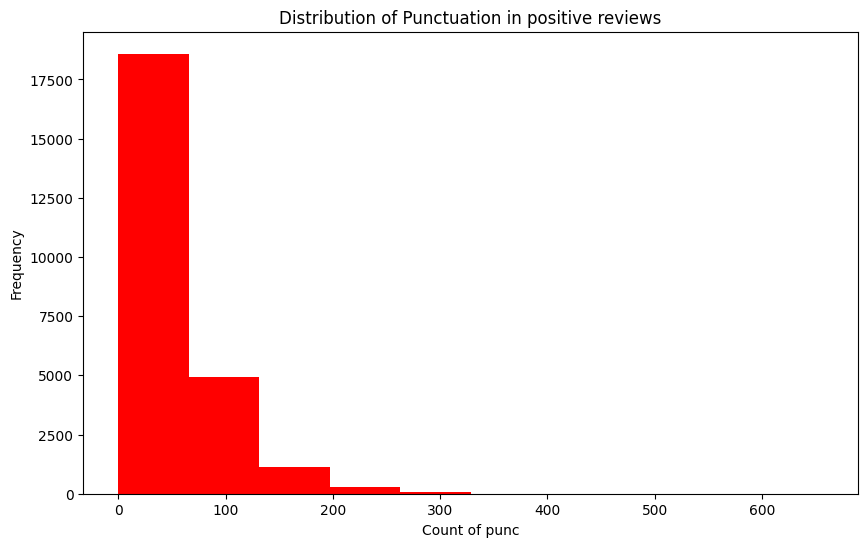

In [17]:
punc_count = [len(re.findall(r'[^\w\s]' , text))for text in review_positive['review']]
plt.figure(figsize=(10,6))

print(len(punc_count))

plt.hist(punc_count , color = "red")
plt.title("Distribution of Punctuation in positive reviews")
plt.xlabel("Count of punc")
plt.ylabel("Frequency")
plt.show()



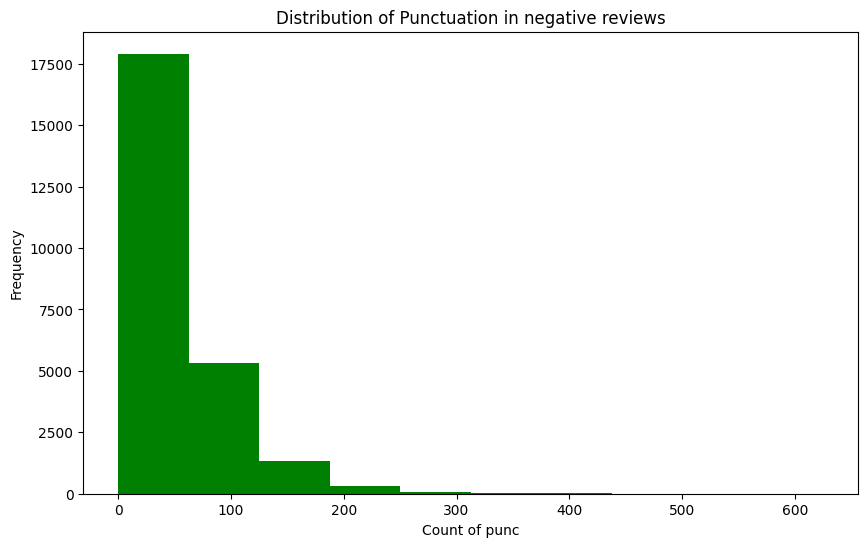

In [18]:
punc_count = [len(re.findall(r'[^\w\s]' , text))for text in review_negative['review']]
plt.figure(figsize=(10,6))

plt.hist(punc_count , color = "green")
plt.title("Distribution of Punctuation in negative reviews")
plt.xlabel("Count of punc")
plt.ylabel("Frequency")
plt.show()

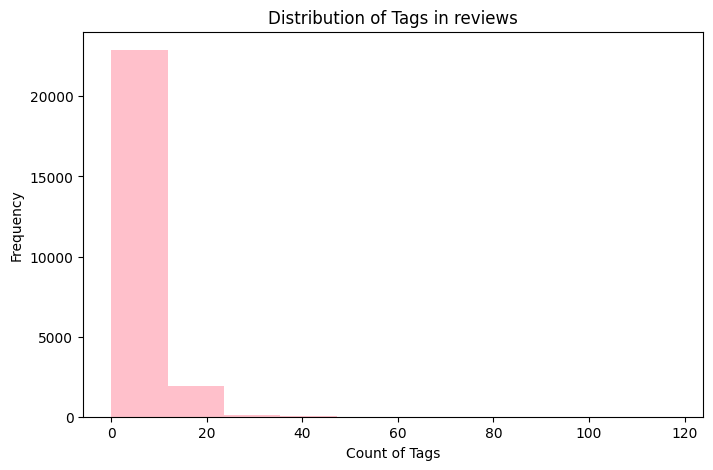

In [19]:
tag_count=[len(re.findall(r'<[^>]+>',text)) for text in review_positive['review']]


plt.figure(figsize = (8,5))
plt.hist(tag_count , color = "pink")
plt.title("Distribution of Tags in reviews")
plt.xlabel("Count of Tags")
plt.ylabel("Frequency")
plt.show()

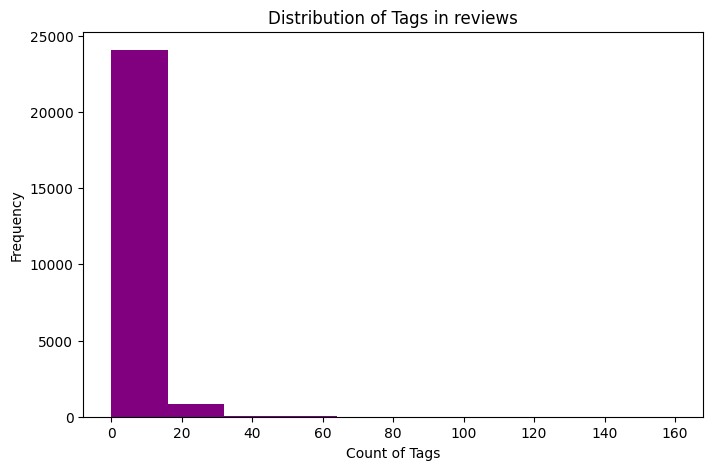

In [20]:
tag_count=[len(re.findall(r'<[^>]+>',text)) for text in review_negative['review']]

plt.figure(figsize = (8,5))
plt.hist(tag_count , color = "purple")
plt.title("Distribution of Tags in reviews")
plt.xlabel("Count of Tags")
plt.ylabel("Frequency")
plt.show()

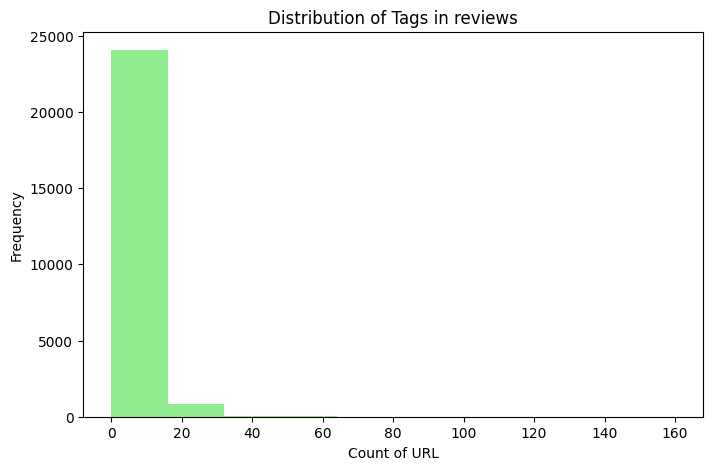

In [21]:
url_count=[len(re.findall(r'https?://\S+|www\.S+' , text)) for text in review_positive['review']]

plt.figure(figsize = (8,5))
plt.hist(tag_count , color = "lightgreen")
plt.title("Distribution of Tags in reviews")
plt.xlabel("Count of URL")
plt.ylabel("Frequency")
plt.show()

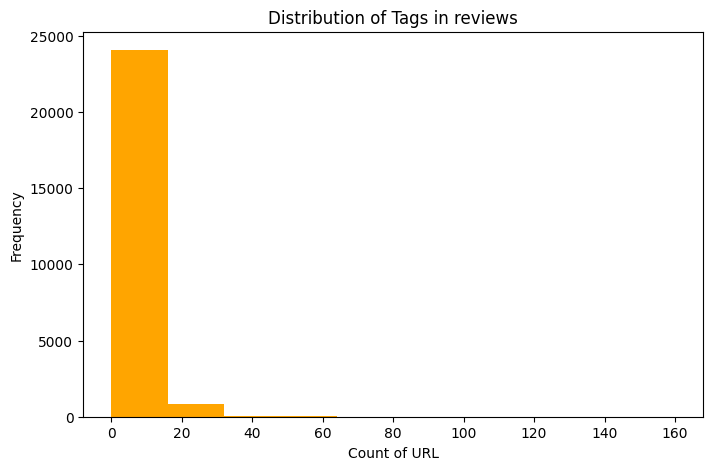

In [22]:
url_count=[len(re.findall(r'https?://\S+|www\.S+' , text)) for text in review_negative['review']]

plt.figure(figsize = (8,5))
plt.hist(tag_count , color = "orange")
plt.title("Distribution of Tags in reviews")
plt.xlabel("Count of URL")
plt.ylabel("Frequency")
plt.show()

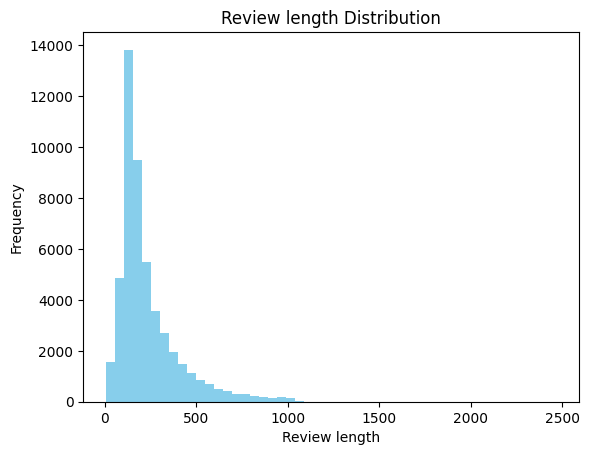

In [23]:
#Length of each review by counting the number of words present

imbd_data['review_length'] = imbd_data['review'].apply(lambda x:len(x.split()))


plt.hist(imbd_data['review_length'],bins = 50 , color = "skyblue")
plt.xlabel("Review length")
plt.ylabel("Frequency")
plt.title("Review length Distribution")
plt.show()

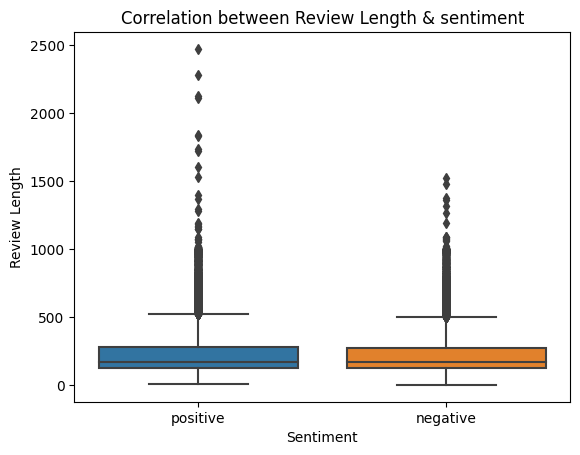

In [24]:
#Co-Relation of Review length and the Sentiment of it
sns.boxplot(x='sentiment' , y ='review_length',data=imbd_data)
plt.xlabel("Sentiment")
plt.ylabel("Review Length")
plt.title("Correlation between Review Length & sentiment")
plt.show()



In [25]:
'''The plot suggests that review 
length is not strongly correlated with sentiment, 
as both positive and negative reviews exhibit similar 
distributions in terms of length. However, positive reviews 
might have slightly longer lengths on average, and there are more 
extreme cases of long reviews in the positive category. 
This could imply that when users are happy with a product or service, 
they might be more inclined to write detailed,
longer reviews, though this is not a strong trend.'''

'The plot suggests that review \nlength is not strongly correlated with sentiment, \nas both positive and negative reviews exhibit similar \ndistributions in terms of length. However, positive reviews \nmight have slightly longer lengths on average, and there are more \nextreme cases of long reviews in the positive category. \nThis could imply that when users are happy with a product or service, \nthey might be more inclined to write detailed,\nlonger reviews, though this is not a strong trend.'

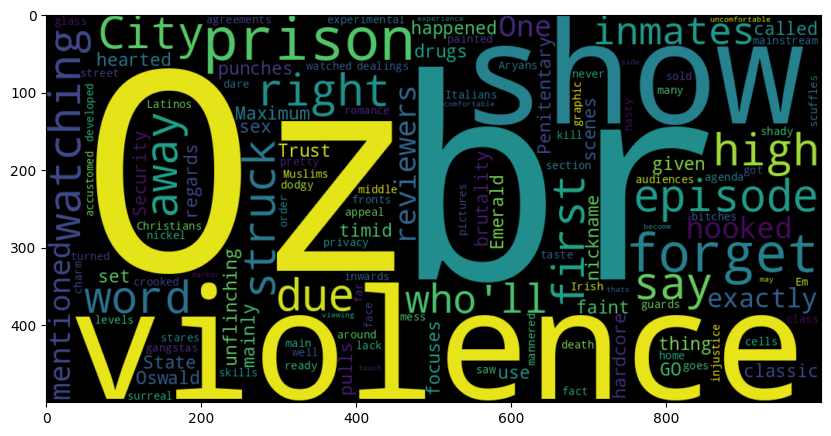

In [26]:
from wordcloud import WordCloud

#Generating word cloud

plt.figure(figsize = (10,20))
positive_text = imbd_data.iloc[0]['review']
wc = WordCloud(width = 1000 , height = 500 , max_words = 600, min_font_size = 10)
positive_words = wc.generate(positive_text)

plt.imshow(positive_words , interpolation="bilinear")
plt.show()

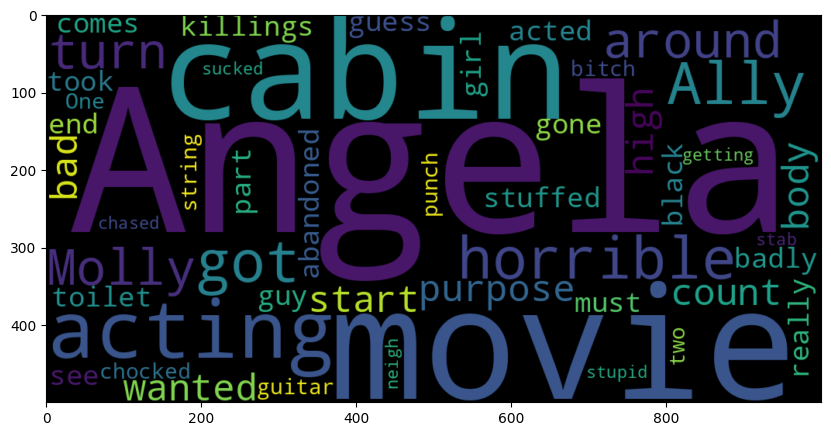

In [27]:
from wordcloud import WordCloud

#Generating word cloud

plt.figure(figsize = (10,20))
positive_text = imbd_data.iloc[25000]['review']
wc = WordCloud(width = 1000 , height = 500 , max_words = 600, min_font_size = 10)
positive_words = wc.generate(positive_text)

plt.imshow(positive_words , interpolation="bilinear")
plt.show()

# Data Preprocessing


In [28]:
#Removing URLS from the texts
def remove_urls(text):
    remove_url = re.compile(r"https://\S+|www\.\S+")
    text = remove_url.sub(r' ',text)
    return text

In [29]:
def strip_html(text):
    s = BeautifulSoup(text , "html.parser")
    return s.get_text()

In [30]:
def remove_punc(text):
    punc = re.compile(r'[^\w\s]')
    text = punc.sub(r' ',text)
    return text

In [31]:
def remove_bracket(text):
    return re.sub('\[[^]*\]',' ',text)
def remove_spe_char(text , digit=True):
    patt = r'[^a-zA-Z0-9\s]'
    text = re.sub(patt , ' ' , text)
    return text

In [32]:
#Lemmatize the corpus
def lemmatize_traincorpus(text):
    lemmatizer = WordNetLemmatizer()
    output = ""
    for word in text:
        output += lemmatizer.lemmatize(word)
    return output

In [33]:
#Funtion to perform stemming using porter stemmer
def stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [34]:
#Tokenization
tokenizer = ToktokTokenizer()

In [35]:
#Creating list of stop words
stopwords = set(stopwords.words('english'))
print(stopwords)

{'her', 'we', 'if', 'more', 'shan', 'down', "aren't", 'd', 'both', 'will', 'didn', 'an', 'below', "weren't", 'couldn', 'am', 'ourselves', 'don', "don't", 'were', 'did', 'how', 'ain', 'is', 'once', 'out', 'each', 'yourselves', "it's", "couldn't", 'before', 'after', 'own', 'a', 'why', 'as', 'was', 'until', 'who', 'myself', 'she', 'doesn', 'hasn', 'any', 'wouldn', 'into', 'mustn', 'which', 've', 'themselves', "wouldn't", 'too', 'from', 'are', 'so', "doesn't", 'his', 'ours', 'the', 'its', 'when', "should've", 'hadn', "needn't", 'being', 'here', 'most', 'whom', 'our', 'shouldn', 'o', 'only', 'on', 'aren', 'should', 'isn', 'i', 'but', "didn't", 'be', 'hers', 'those', "she's", 'because', 'then', 'nor', 'what', 'has', 'and', 'there', 'had', 'them', 'under', 'herself', 'by', 'about', 'other', 'won', 'further', 'just', 'through', 'up', 'having', 'can', 'haven', "mightn't", 'between', "won't", 'this', 'your', 'himself', 'no', 'does', 'weren', 'in', 'yours', "that'll", 'against', 'some', 'it', 'do

In [36]:
#Now removing these stop words from the text
def remove_stopwords(text , lowercase = False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if lowercase:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
        
    filtered_text = " ".join(filtered_tokens)
    return filtered_text

In [37]:
#Now applying and removing the urls , punctuations and html from the review section of the data


imbd_data['review'] = imbd_data['review'].apply(lambda z : remove_punc(z))

imbd_data['review'] = imbd_data['review'].apply(lambda z : strip_html(z))

imbd_data['review'] = imbd_data['review'].apply(lambda z : remove_urls(z))

In [38]:
#counting the numver of good and vad sentiments in dataset
count_pos = imbd_data[imbd_data['sentiment'] == 'positive']
count_neg = imbd_data[imbd_data['sentiment'] == 'negative']

print(len(count_pos) , len(count_neg))

25000 25000


In [39]:
#replacing the pos = 1 and neg = 0

imbd_data['sentiment'] = imbd_data['sentiment'].replace({'positive':1 , 'negative':0})
imbd_data.head()

/tmp/ipykernel_36/379307714.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  imbd_data['sentiment'] = imbd_data['sentiment'].replace({'positive':1 , 'negative':0})


,review,sentiment,Word Count,Numeric Count,Mentions,Uppercase Count,review_length
0,One of the other reviewers has mentioned that ...,1,307,1,0,43,307
1,A wonderful little production br br The...,1,162,0,0,16,162
2,I thought this was a wonderful way to spend ti...,1,166,1,0,23,166
3,Basically there s a family where a little boy ...,0,138,3,0,24,138
4,Petter Mattei s Love in the Time of Money is...,1,230,0,0,34,230


In [40]:
#Creating copy of dataframe/set for other models

df_m = imbd_data.copy()


In [41]:
#Applying stemmer to the copy of dataframe

df_m['review'] = df_m['review'].apply(lambda z : stemmer(z))

In [42]:
df_m['review'] = df_m['review'].apply(lambda z : remove_stopwords(z))

In [43]:
#Labeling the sentiment data using LabelBinarizer
lb = LabelBinarizer()
sentiment_data = lb.fit_transform(imbd_data['sentiment'])

In [44]:
df_m['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [45]:
sentiment_data

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [46]:
cv = CountVectorizer(
    min_df = 0.01, #Ignore  terms appearing less than 1%
    max_df = 0.99, #ignore  terms appering more than 99%
    binary = False, #ignore and count the number of times term appear
    ngram_range=(1,3) #include unigram , bigram and trigrams
)

In [47]:
#Initialize tfidVectorizer with specified parameters
tv = TfidfVectorizer(
    min_df=0.01,#Ignore  terms appearing less than 1%
    max_df=0.99,#ignore  terms appering more than 99%
    use_idf = True,#Enable inverse-document-frequency reweight
    ngram_range = (1,3)#include unigram , bigram and trigrams
)

In [48]:
#Spliting the data set into training and dev/test set
X_train , X_test , y_train , y_test = train_test_split(
    df_m['review'],#Feature
    df_m['sentiment'],#Target variable
    test_size = 0.2 #20% of the data will be for testing
)
print(X_train)
print(X_train.shape , X_test.shape)

2805     movi seem made befor readi watch thi film made...
28037    mean noth happen 5 dumb kid go oklahoma find m...
39612    happen director nephew taken year get hand cop...
2664     actual answer onli occupi tini portion thi exc...
6214     never heard book care read movi probabl see ma...
                               ...                        
24106    walk dinosaur amaz documentari educ ignor dino...
19071    work music store collegu first tip thi soundtr...
6067     excel film whole pictur wa film budapest feel ...
14730    holi crap terribl terribl spanish thriller fou...
11494    thi 1 hour 30 minut insid joke best understood...
Name: review, Length: 40000, dtype: object
(40000,) (10000,)


# Bag of words and tf-ifd approach


In [49]:
#Tranforming reviews into BOW vectors for both train and test set
cv_train_reviews = cv.fit_transform(X_train)
cv_test_reviews = cv.transform(X_test)

# print(cv_train_reviews.shape)

In [50]:
tv_train_reviews = tv.fit_transform(X_train)
tv_test_reviews = tv.transform(X_test)



In [51]:
def plot_cf_matrix(cm , title , cmap = plt.cm.Blues):
    plt.figure(figsize = (10,6))
    
    plt.imshow(cm , interpolation = 'nearest',cmap = cmap)
    plt.title(title)
    plt.colorbar()
    
    classes = ['Negative Sentiment' , 'Positive Sentiment']
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes , rotation = 45)
    plt.yticks(tick_marks , classes)
    
    fmt = 'd'
    thresh= cm.max() / 2
    for i , j in itertools.product(range(cm.shape[0]) , range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j] , fmt),
                horizontalalignment = 'center',
                color = 'white' if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
        

In [52]:
def plt_roc_curve(y_true , y_prob , title = "ROC curve"):
    fpr , tpr , thresholds = roc_curve(y_true , y_prob)
    auc = roc_auc_score(y_true , y_prob)
    
    plt.figure(figsize=(10,6))
    plt.plot(fpr , tpr , color = "green" , lw = 2 , label = f'AUC = {auc:.2f}')
    plt.plot([0,1] , [0,1] , color = 'navy' , lw = 2  , linestyle = '--')
    plt.xlim([0.0 , 1.0])
    plt.ylim([0.0 , 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel("True positive rate")
    plt.title(title)
    plt.legend(loc = 'lower right')
    plt.show()

## 1. Logistic Regression

In [53]:
lr = LogisticRegression(penalty  = 'l2' , max_iter = 1000 , C= 1) #Regularization of L2 and max_itr = 1000 

In [54]:
lr_bow = lr.fit(cv_train_reviews , y_train)
lr_tfidf = lr.fit(tv_train_reviews , y_train)

In [55]:
lr_bow_predict = lr.predict(cv_test_reviews)
lr_tfidf_predict = lr.predict(tv_test_reviews)

In [56]:
#Accuracy
lr_bow_score = accuracy_score(y_test , lr_bow_predict)
print("Accuracy of:",lr_bow_score)
lr_tfidf_score = accuracy_score(y_test , lr_tfidf_predict)
print("Accuracy of :",lr_tfidf_score )

Accuracy of: 0.8638
Accuracy of : 0.8752


In [57]:
print("Classification report for the bag of words")

lr_bow_report = classification_report(y_test , lr_bow_predict , target_names = ['Negative' , 'Positive'])
print(lr_bow_report)

Classification report for the bag of words
              precision    recall  f1-score   support

    Negative       0.85      0.88      0.87      5015
    Positive       0.88      0.85      0.86      4985

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [58]:
print("Classification report for TF-IDF")
lr_tfidf_report = classification_report(y_test , lr_tfidf_predict , target_names = ['Negative' , 'Positive'])
print(lr_tfidf_report)

Classification report for TF-IDF
              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87      5015
    Positive       0.87      0.88      0.88      4985

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



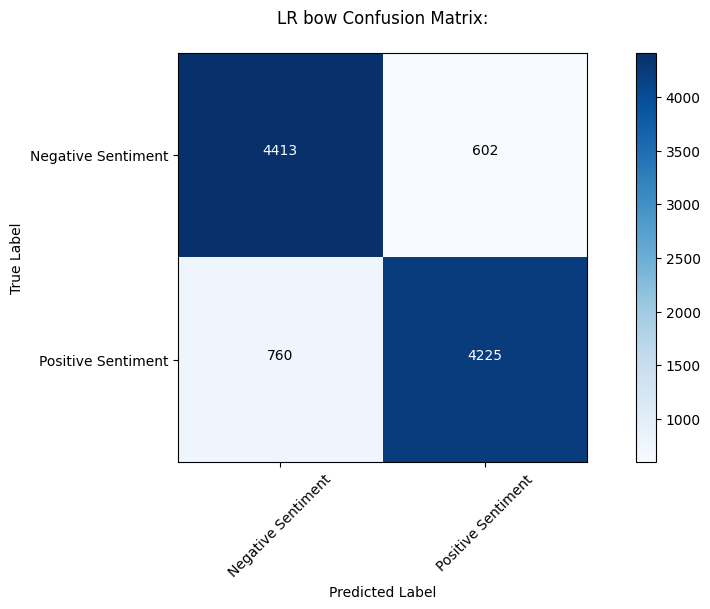

In [59]:
#cf matrix for bag of words

cm_bow = confusion_matrix(y_test,lr_bow_predict)
plot_cf_matrix(cm_bow,"LR bow Confusion Matrix:\n")

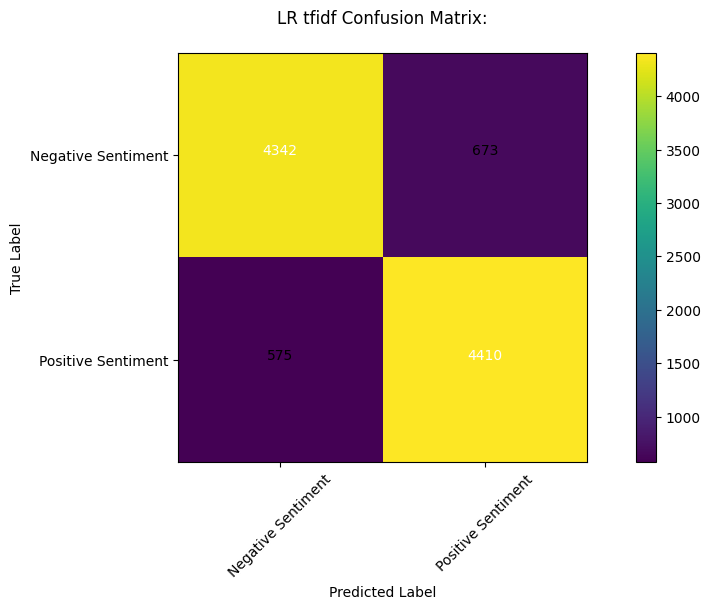

In [60]:
#cf matrix for TF-IDF

cm_tfidf = confusion_matrix(y_test,lr_tfidf_predict)
plot_cf_matrix(cm_tfidf,"LR tfidf Confusion Matrix:\n" , cmap = plt.cm.viridis)

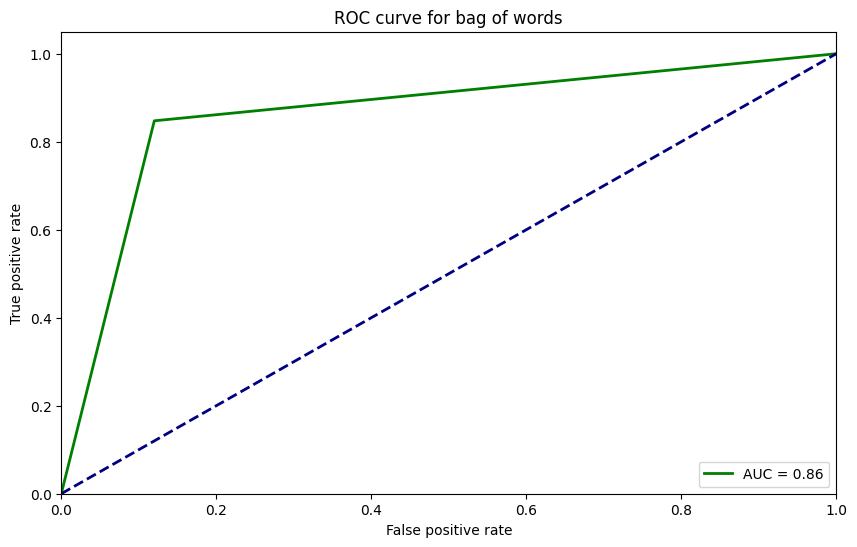

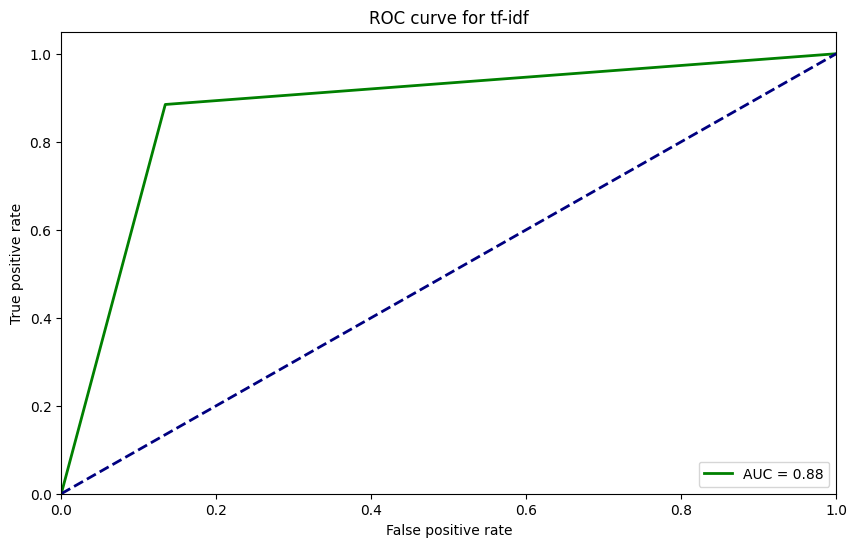

In [61]:
#ROC curve for bag of words
plt_roc_curve(y_test , lr_bow_predict , "ROC curve for bag of words")

#ROC curve for TFIDF features
plt_roc_curve(y_test , lr_tfidf_predict , "ROC curve for tf-idf")

## 2. Multinomial Naive Bayes

In [62]:
mnb = MultinomialNB()

In [63]:
mnb_bow = mnb.fit(cv_train_reviews , y_train)
mnb_tfidf = mnb.fit(tv_train_reviews , y_train)

In [64]:
mnb_bow_predict = mnb.predict(cv_test_reviews)
mnb_tfidf_predict = mnb.predict(tv_test_reviews)

In [65]:
#Accuracy score of bow and tfidf

mnb_bow_score = accuracy_score(y_test , mnb_bow_predict)
print("mnb_bow_score" , mnb_bow_score)
mnb_tfidf_score = accuracy_score(y_test , mnb_tfidf_predict)
print("mnb_tfidf_score" , mnb_tfidf_score)


mnb_bow_score 0.8412
mnb_bow_score 0.8418


In [66]:
print("Classification report for the bag of words")

mnb_bow_report = classification_report(y_test , mnb_bow_predict , target_names = ['Negative' , 'Positive'])
print(mnb_bow_report)

Classification report for the bag of words
              precision    recall  f1-score   support

    Negative       0.84      0.85      0.84      5015
    Positive       0.84      0.84      0.84      4985

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [67]:
print("Classification report for TF-IDF")
mnb_tfidf_report = classification_report(y_test , mnb_tfidf_predict , target_names = ['Negative' , 'Positive'])
print(mnb_tfidf_report)

Classification report for TF-IDF
              precision    recall  f1-score   support

    Negative       0.86      0.82      0.84      5015
    Positive       0.83      0.86      0.84      4985

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



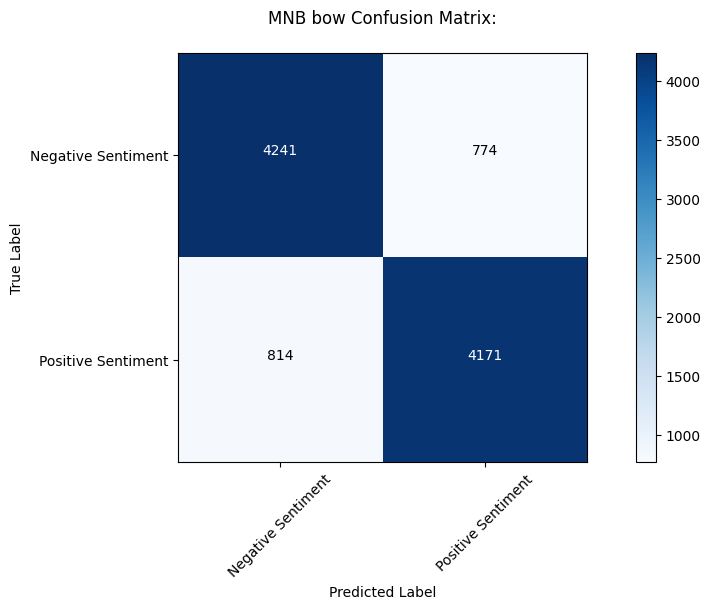

In [68]:
#cf matrix for bag of words

mnb_cm_bow = confusion_matrix(y_test,mnb_bow_predict)
plot_cf_matrix(mnb_cm_bow,"MNB bow Confusion Matrix:\n")

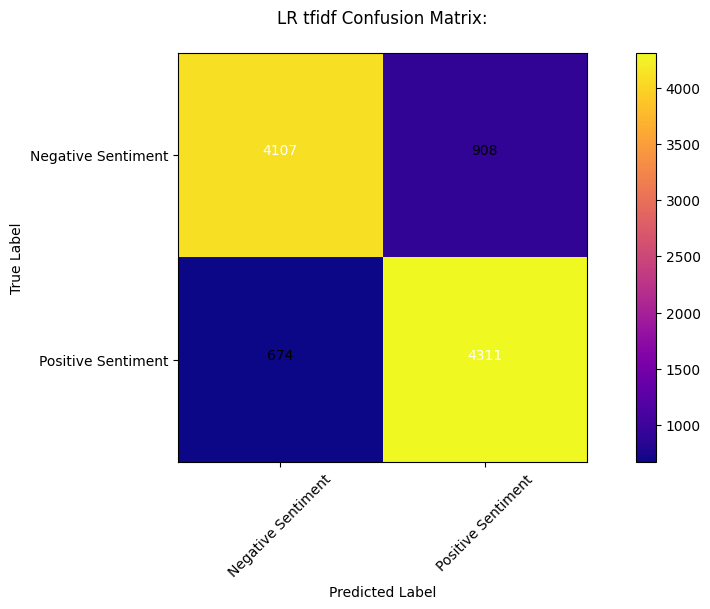

In [69]:
#cf matrix for TF-IDF

mnb_cm_tfidf = confusion_matrix(y_test,mnb_tfidf_predict)
plot_cf_matrix(mnb_cm_tfidf,"LR tfidf Confusion Matrix:\n" , cmap = plt.cm.plasma)

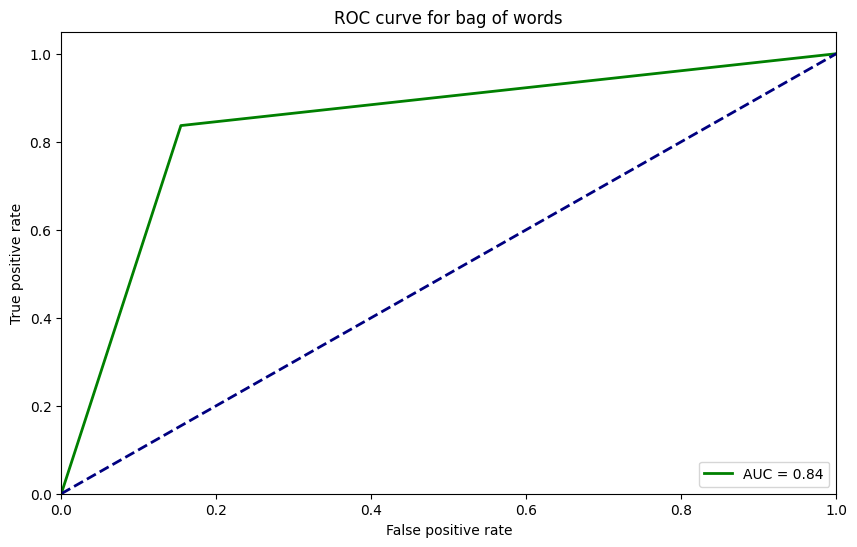

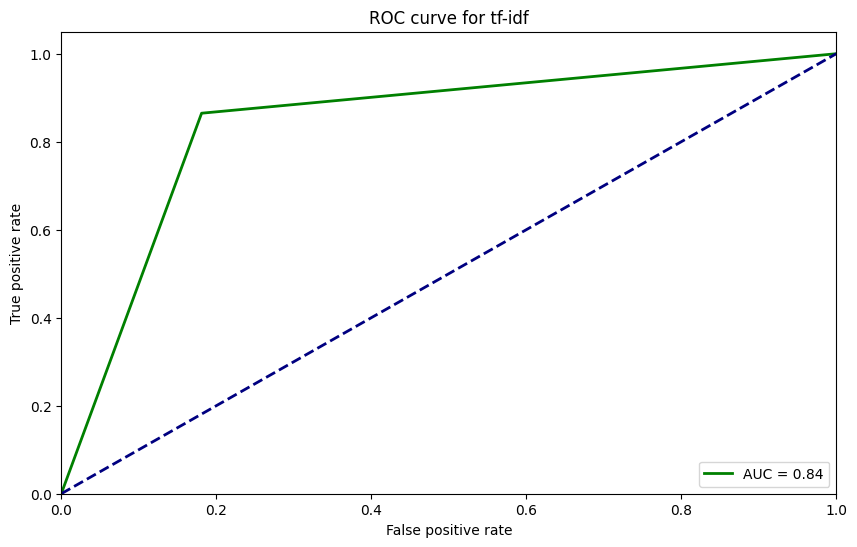

In [70]:
#ROC curve for bag of words
plt_roc_curve(y_test , mnb_bow_predict , "ROC curve for bag of words")

#ROC curve for TFIDF features
plt_roc_curve(y_test , mnb_tfidf_predict , "ROC curve for tf-idf")

## 3.Stochastic Gradient Descent

In [71]:
#initial the SGD Classifier
sgd = SGDClassifier(loss = "hinge" , max_iter= 1000)

In [72]:
sgd_bow = sgd.fit(cv_train_reviews , y_train)
sgd_tfidf = sgd.fit(tv_train_reviews , y_train)

In [73]:
sgd_bow_predict = sgd.predict(cv_test_reviews)
sgd_tfidf_predict = sgd.predict(tv_test_reviews)

In [74]:
#Accuracy score of bow and tfidf

sgd_bow_score = accuracy_score(y_test , sgd_bow_predict)
print("sgd_bow_score" , sgd_bow_score)
sgd_tfidf_score = accuracy_score(y_test , sgd_tfidf_predict)
print("sgd_bow_score" , sgd_tfidf_score)



sgd_bow_score 0.8623
sgd_bow_score 0.8704


In [75]:
print("Classification report for the bag of words")

sgd_bow_report = classification_report(y_test , sgd_bow_predict , target_names = ['Negative' , 'Positive'])
print(sgd_bow_report)

Classification report for the bag of words
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.86      5015
    Positive       0.87      0.85      0.86      4985

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [76]:
print("Classification report for TF-IDF")
sgd_tfidf_report = classification_report(y_test , sgd_tfidf_predict , target_names = ['Negative' , 'Positive'])
print(sgd_tfidf_report)

Classification report for TF-IDF
              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87      5015
    Positive       0.86      0.89      0.87      4985

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



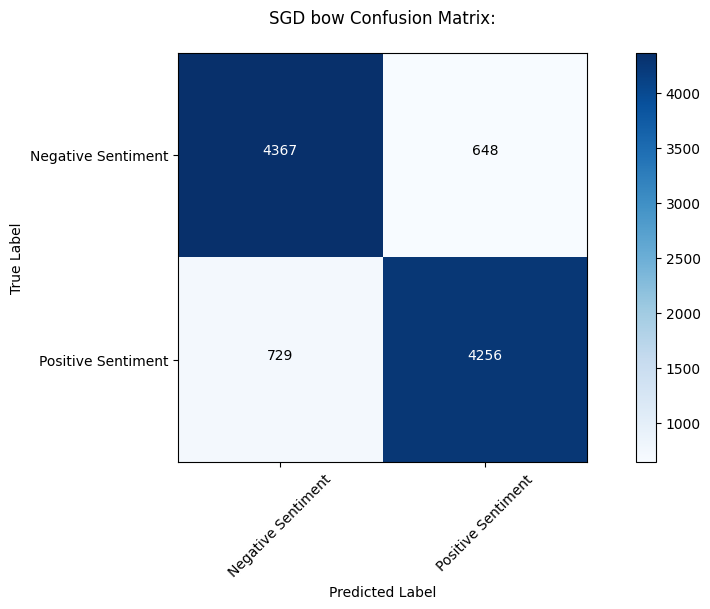

In [77]:
#cf matrix for bag of words

sgd_cm_bow = confusion_matrix(y_test,sgd_bow_predict)
plot_cf_matrix(sgd_cm_bow,"SGD bow Confusion Matrix:\n")

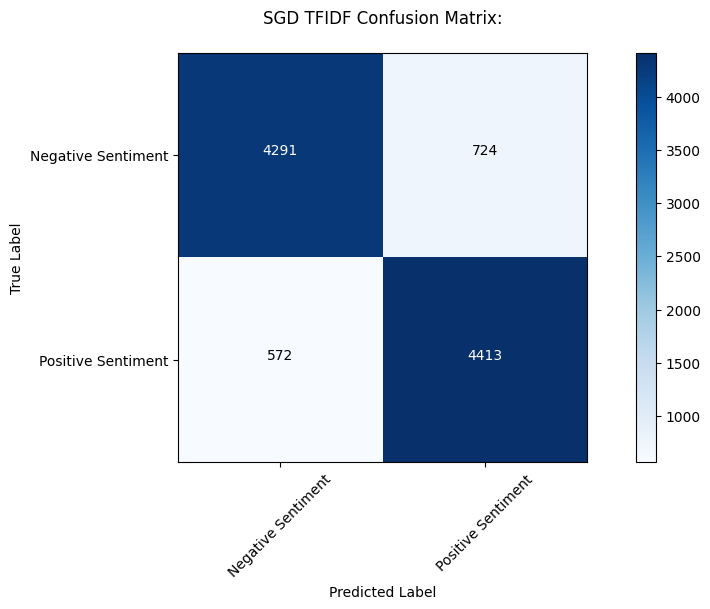

In [78]:
#cf matrix for bag of words

sgd_cm_tfidf = confusion_matrix(y_test,sgd_tfidf_predict)
plot_cf_matrix(sgd_cm_tfidf,"SGD TFIDF Confusion Matrix:\n")

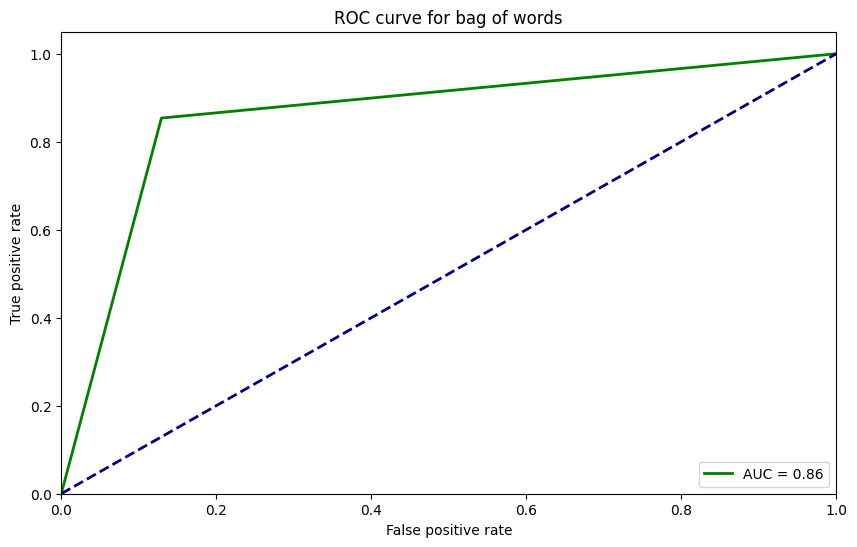

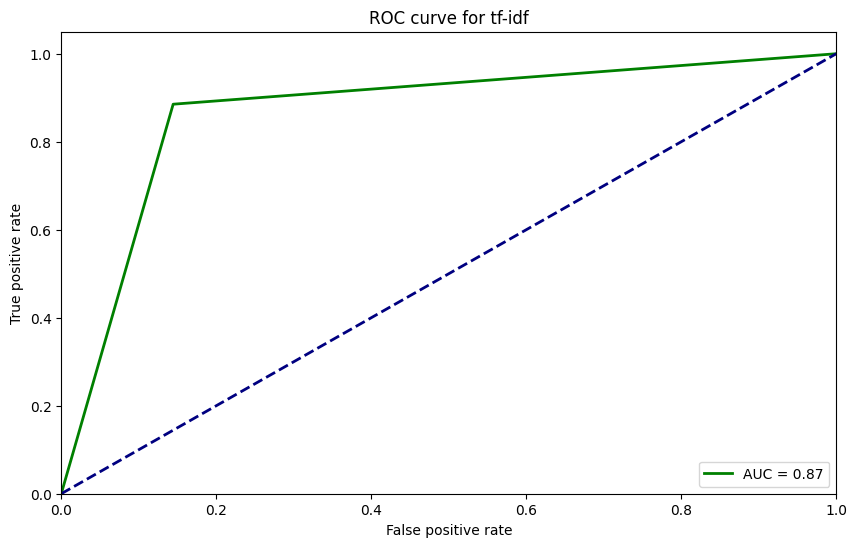

In [79]:
#ROC curve for bag of words
plt_roc_curve(y_test , sgd_bow_predict , "ROC curve for bag of words")

#ROC curve for TFIDF features
plt_roc_curve(y_test , sgd_tfidf_predict , "ROC curve for tf-idf")

## 4. Random Forest


In [80]:
rf = RandomForestClassifier()

In [82]:
#Training the rf classifier with BOW and TF-IDF
rf_bow = rf.fit(cv_train_reviews , y_train)
rf_tfidf = rf.fit(tv_train_reviews , y_train)

In [83]:
#Calculating the result on testing set
rf_bow_predict = rf.predict(cv_test_reviews)
rf_tfidf_predict = rf.predict(tv_test_reviews)

In [84]:
#Accuracy of bow and tfidf
rf_bow_score = accuracy_score(y_test , rf_bow_predict)
rf_tfidf_score = accuracy_score(y_test , rf_tfidf_predict)

print("RF bow score" ,rf_bow_score )
print("RF tfidf score" ,rf_tfidf_score )


RF bow score 0.6752
RF tfidf score 0.8336


In [85]:
print("Classification report for the bag of words")

rf_bow_report = classification_report(y_test , rf_bow_predict , target_names = ['Negative' , 'Positive'])
print(rf_bow_report)

Classification report for the bag of words
              precision    recall  f1-score   support

    Negative       0.65      0.75      0.70      5015
    Positive       0.70      0.60      0.65      4985

    accuracy                           0.68     10000
   macro avg       0.68      0.67      0.67     10000
weighted avg       0.68      0.68      0.67     10000



In [86]:
print("Classification report for the tfidf")

rf_tfidf_report = classification_report(y_test , rf_tfidf_predict , target_names = ['Negative' , 'Positive'])
print(rf_tfidf_report)

Classification report for the tfidf
              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83      5015
    Positive       0.83      0.84      0.83      4985

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



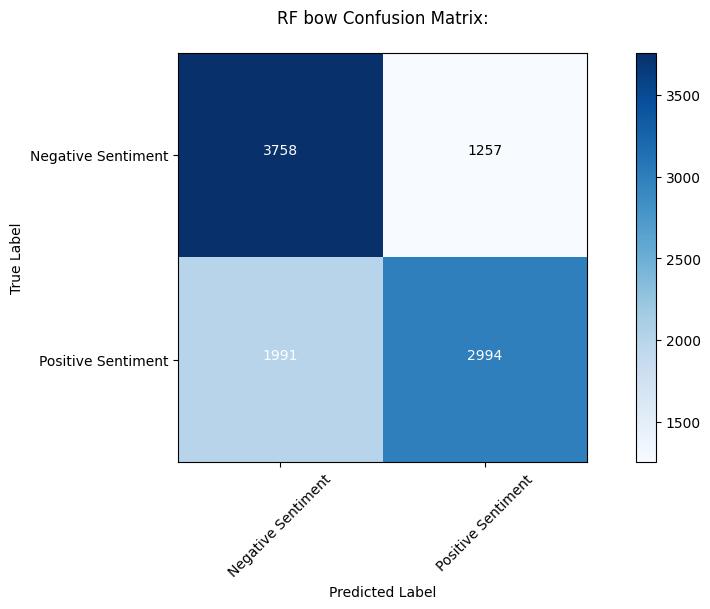

In [87]:
#cf matrix for bag of words

rf_cm_bow = confusion_matrix(y_test,rf_bow_predict)
plot_cf_matrix(rf_cm_bow,"RF bow Confusion Matrix:\n")

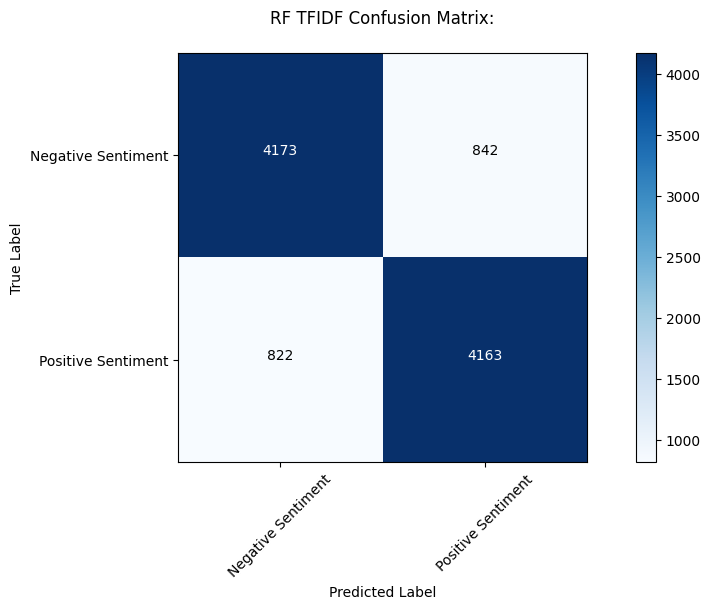

In [88]:
#cf matrix for TFIDF

rf_cm_tfidf = confusion_matrix(y_test,rf_tfidf_predict)
plot_cf_matrix(rf_cm_tfidf,"RF TFIDF Confusion Matrix:\n")

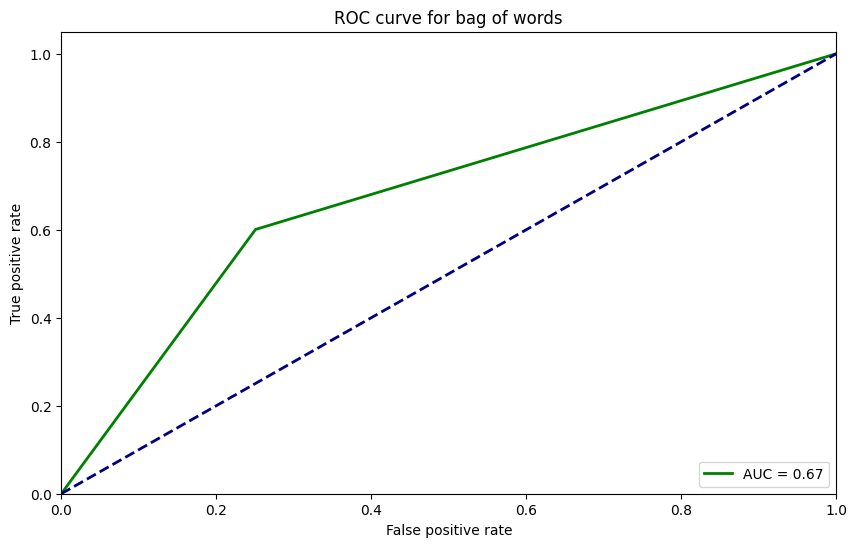

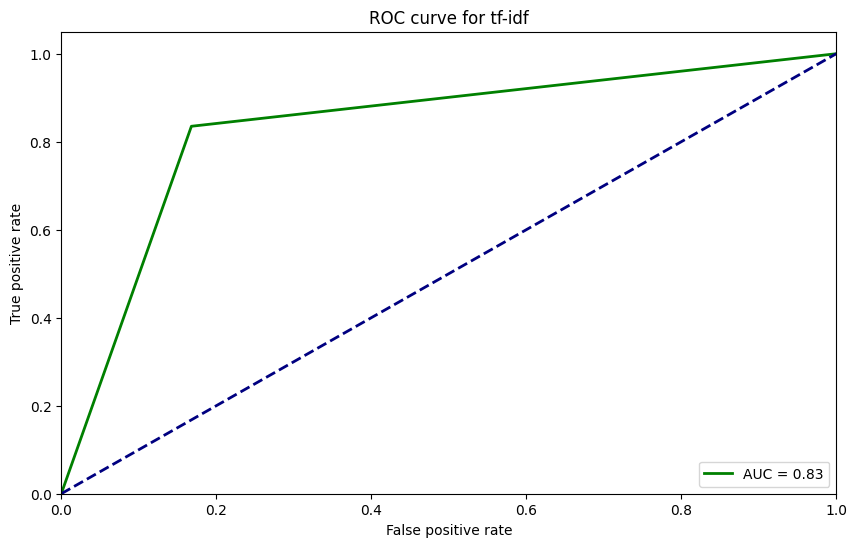

In [89]:
#ROC curve for bag of words
plt_roc_curve(y_test , rf_bow_predict , "ROC curve for bag of words")

#ROC curve for TFIDF features
plt_roc_curve(y_test , rf_tfidf_predict , "ROC curve for tf-idf")

## 5. SVM

In [ ]:
svm = SVC()

In [ ]:
#Training SVM
svm_bow = svm.fit(cv_train_reviews , y_train)
svm_tfidf = svm.fit(tv_train_reviews , y_train)

In [ ]:
#Calculating the result on testing set
svm_bow_predict = svm.predict(cv_test_reviews)
svm_tfidf_predict = svm.predict(tv_test_reviews)

In [ ]:
#Accuracy of bow and tfidf
svm_bow_score = accuracy_score(y_test , svm_bow_predict)
svm_tfidf_score = accuracy_score(y_test , svm_tfidf_predict)

print("RF bow score" ,svm_bow_score )
print("RF tfidf score" ,svm_tfidf_score )


In [ ]:
print("Classification report for the bag of words")

svm_bow_report = classification_report(y_test , svm_bow_predict , target_names = ['Negative' , 'Positive'])
print(svm_bow_report)

In [ ]:
print("Classification report for the tfidf")

svm_tfidf_report = classification_report(y_test , svm_tfidf_predict , target_names = ['Negative' , 'Positive'])
print(svm_tfidf_report)

In [ ]:
#cf matrix for bag of words

svm_cm_bow = confusion_matrix(y_test,svm_bow_predict)
plot_cf_matrix(svm_cm_bow,"RF bow Confusion Matrix:\n")

#cf matrix for TFIDF

svm_cm_tfidf = confusion_matrix(y_test,svm_tfidf_predict)
plot_cf_matrix(svm_cm_tfidf,"RF TFIDF Confusion Matrix:\n")

In [ ]:
#ROC curve for bag of words
plt_roc_curve(y_test , svm_bow_predict , "ROC curve for bag of words")

#ROC curve for TFIDF features
plt_roc_curve(y_test , svm_tfidf_predict , "ROC curve for tf-idf")

# 2.1 Deep Learning model


In [105]:
vocab_size = 100000 
embedding_dims = 16
max_length = 22
trunc_type = 'post'
oov_tok = '<OOV>'

In [106]:
#Function to plot dev and train accuracy
def plt_acc_graph(history):
    plt.plot(history.history['accuracy'] , 'b', label = 'Training Accuracy')
    plt.plot(history.history['val_accuracy'] , 'g' ,label = 'Validation accuracy')
    plt.title("Training and validation accuracy")
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.legend(loc = 'upper left')
    plt.show()

In [107]:
df_dl = imbd_data.copy()

In [123]:
#PLOT the training and validation loss

def plt_loss_graph(history):
    plt.plot(history.history['loss'] , 'r' , label = "Training Loss")
    plt.plot(history.history['val_loss'] , 'm' , label = 'Validation loss')
    plt.title("Training and Validation lOSS")
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend(loc = 'upper right')
    plt.show()

In [109]:
X_train , X_test , y_train , y_test = train_test_split(df_dl['review'] , df_dl['sentiment'] , test_size = 0.2)


In [110]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [111]:
tokenizer = Tokenizer(num_words = vocab_size , oov_token = oov_tok)

tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(X_train)

padded = pad_sequences(sequences , maxlen = max_length , truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)

testing_padded = pad_sequences(testing_sequences , maxlen = max_length)




In [117]:

# Defining sequential model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dims, input_length=max_length),
    tf.keras.layers.Flatten(),  # Converting 2D input to 1D
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model by specifying the input shape
model.build(input_shape=(None, max_length))

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 22, 16)         │     1,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        45,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,653,505 (6.31 MB)

 Trainable params: 1,653,505 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [119]:
y_train

,sentiment
24869,1
5241,1
7427,0
26402,1
43334,0
...,...
29901,0
40423,1
12955,0
40838,1


In [120]:
num_epochs = 15
history_custom = model.fit(padded , y_train , epochs = num_epochs , validation_data = (testing_padded , y_test))

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6238 - loss: 0.6224 - val_accuracy: 0.7144 - val_loss: 0.5477
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8401 - loss: 0.3596 - val_accuracy: 0.6834 - val_loss: 0.6297
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9431 - loss: 0.1487 - val_accuracy: 0.6686 - val_loss: 0.9572
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9832 - loss: 0.0480 - val_accuracy: 0.6586 - val_loss: 1.4106
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9933 - loss: 0.0206 - val_accuracy: 0.6614 - val_loss: 1.8840
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9964 - loss: 0.0121 - val_accuracy: 0.6509 - val_loss: 2.4318
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9959 - loss: 0.0133 - val_accuracy: 0.6511 - val_loss: 2.2654
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9978 - loss: 0.0071 - 

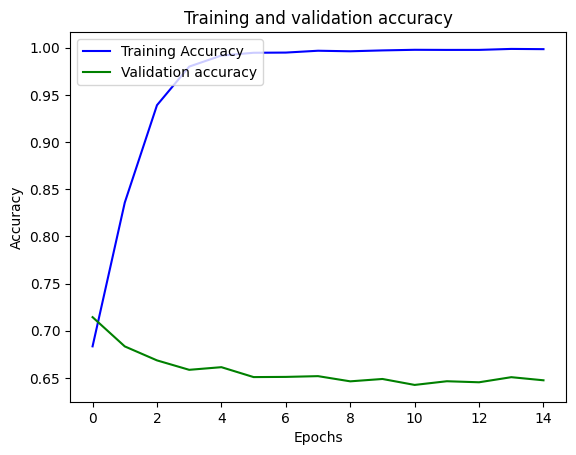

In [121]:
plt_acc_graph(history_custom)

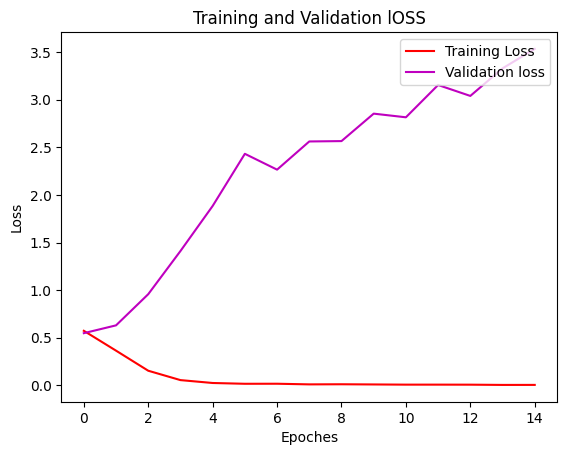

In [124]:
plt_loss_graph(history_custom)


### 2.2 Observation
### We can see that the model is overfitting so to reduce it adding regularization(L2) to avoid over fitting

In [125]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dims, input_length=max_length),
    tf.keras.layers.Flatten(),  # Converting 2D input to 1D
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model by specifying the input shape
model.build(input_shape=(None, max_length))

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 22, 16)         │     1,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        45,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,653,505 (6.31 MB)

 Trainable params: 1,653,505 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
num_epochs = 15
history_custom = model.fit(padded , y_train , epochs = num_epochs , validation_data = (testing_padded , y_test))

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5744 - loss: 0.8702 - val_accuracy: 0.7077 - val_loss: 0.5768
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8034 - loss: 0.4543 - val_accuracy: 0.6981 - val_loss: 0.6035
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9035 - loss: 0.2797 - val_accuracy: 0.6730 - val_loss: 0.7757
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9677 - loss: 0.1307 - val_accuracy: 0.6627 - val_loss: 1.0427
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9866 - loss: 0.0752 - val_accuracy: 0.6689 - val_loss: 1.2979
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9928 - loss: 0.0508 - val_accuracy: 0.6606 - val_loss: 1.5416
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9924 - loss: 0.0449 - val_accuracy: 0.6652 - val_loss: 1.7014
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9931 - loss: 0.0425 - 

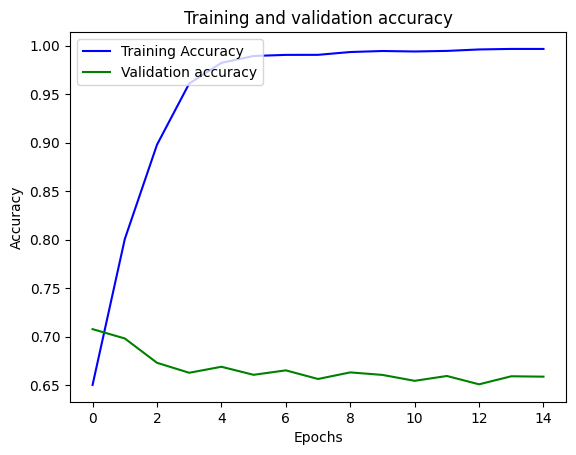

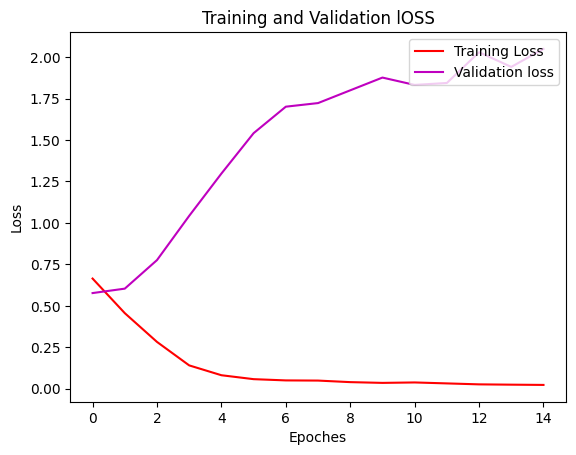

In [127]:
plt_acc_graph(history_custom)
plt_loss_graph(history_custom)

### 2.3Still overfitting  adding dropout and regularization

In [131]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dims, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Increased Dropout
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),  # Add another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model by specifying the input shape
model.build(input_shape=(None, max_length))

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 22, 16)         │     1,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        45,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,653,505 (6.31 MB)

 Trainable params: 1,653,505 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

In [132]:
num_epochs = 15
history_custom = model.fit(padded , y_train , epochs = num_epochs , validation_data = (testing_padded , y_test))


Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5805 - loss: 0.8000 - val_accuracy: 0.7111 - val_loss: 0.5675
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8170 - loss: 0.4398 - val_accuracy: 0.7084 - val_loss: 0.5824
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9142 - loss: 0.2507 - val_accuracy: 0.6794 - val_loss: 0.7686
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9653 - loss: 0.1250 - val_accuracy: 0.6769 - val_loss: 1.0275
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9859 - loss: 0.0640 - val_accuracy: 0.6672 - val_loss: 1.3082
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9943 - loss: 0.0358 - val_accuracy: 0.6647 - val_loss: 1.5616
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9959 - loss: 0.0252 - val_accuracy: 0.6618 - val_loss: 1.6640
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9972 - loss: 0.0195 - 

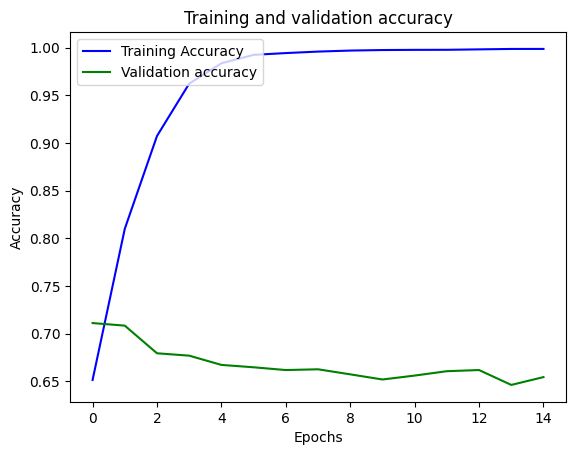

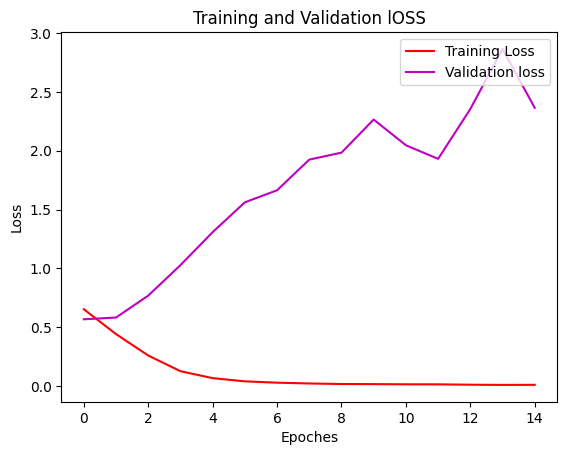

In [133]:
plt_acc_graph(history_custom)
plt_loss_graph(history_custom)

In [134]:
#using early stopping

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dims, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Increased Dropout
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),  # Add another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model by specifying the input shape
model.build(input_shape=(None, max_length))

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 22, 16)         │     1,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        45,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,653,505 (6.31 MB)

 Trainable params: 1,653,505 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

In [135]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_custom = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stopping])


Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5366 - loss: 0.8191 - val_accuracy: 0.7084 - val_loss: 0.5738
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7941 - loss: 0.4760 - val_accuracy: 0.7057 - val_loss: 0.5840
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8934 - loss: 0.2984 - val_accuracy: 0.6830 - val_loss: 0.7034
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9549 - loss: 0.1599 - val_accuracy: 0.6705 - val_loss: 0.9288


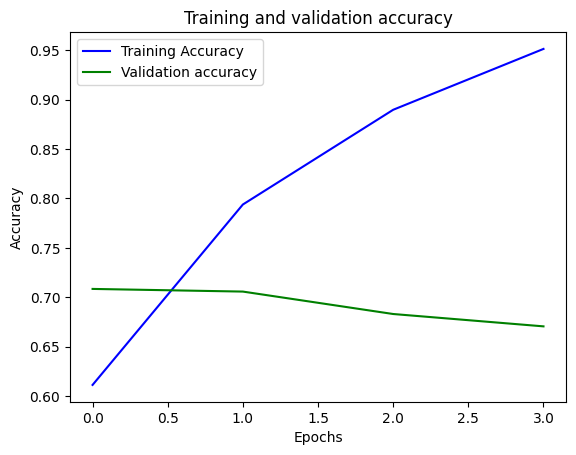

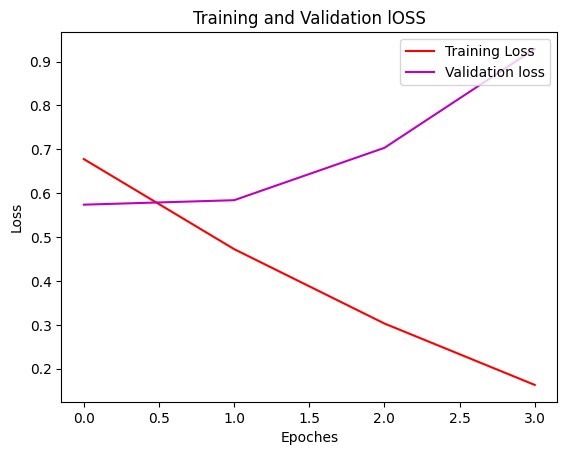

In [136]:
plt_acc_graph(history_custom)
plt_loss_graph(history_custom)

### 7. WordToVec


In [137]:
num_features = 300
min_word_count = 1
num_workers = 4
context = 10
downsampling = 1e-3

In [138]:
sentences = []

for i , row in df_dl.iterrows():
    sentences += row['review'].split()
[sentences[:2]]

[['One', 'of']]

In [140]:
model = word2vec.Word2Vec([sentences],
                          workers = num_workers,
                          vector_size = num_features,
                          min_count = min_word_count,
                          window = context,
                          sample = downsampling
                         )

In [141]:
vocab_words = list(model.wv.key_to_index.keys())
vocab_words[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'I', 'it']

In [142]:
print(model.wv.most_similar('okay'))

[('3', 0.5951356887817383), ('been', 0.5933469533920288), ('those', 0.5913828611373901), ('through', 0.5888278484344482), ('were', 0.5886473059654236), ('just', 0.5879758596420288), ('for', 0.5878229141235352), ('very', 0.5874446630477905), ('there', 0.5870836973190308), ('no', 0.5868631601333618)]


In [143]:
print(model.wv.most_similar('films'))

[('in', 0.9789472222328186), ('of', 0.9788872003555298), ('on', 0.9785693287849426), ('what', 0.9784842729568481), ('to', 0.9784749150276184), ('s', 0.9784582257270813), ('his', 0.9784120321273804), ('the', 0.9783468246459961), ('and', 0.9782899022102356), ('are', 0.9782019257545471)]


In [145]:
def average_word_vectors(words , model , num_features):
    feature_vector = np.zeros(num_features , dtype = "float32")
    word_count = 0
    
    index_to_word_set = set(model.wv.index_to_key)
    
    for word in words.split():
        if word in index_to_word_set:
            word_count += 1 
            feature_vector = np.add(feature_vector , model.wv.get_vector(word))
    if(word_count > 0):
        feature_vector = np.divide(feature_vector , word_count)
    return feature_vector

In [151]:
def get_avg_ftr_vec(reviews , model , num_features):
    counter = 0
    review_feature_vecs = np.zeros((len(reviews) , num_features), dtype="float32")
    for review in reviews:
        if (counter % 10000 == 0):
            print("Review",counter ,"of",len(reviews))
        review_feature_vecs[counter] = average_word_vectors(review , model , num_features)
        counter +=1
    return review_feature_vecs

In [153]:
trainVectors = get_avg_ftr_vec(X_train , model , num_features)
testVectors = get_avg_ftr_vec(X_test , model , num_features)

Review 0 of 40000
Review 10000 of 40000
Review 20000 of 40000
Review 30000 of 40000
Review 0 of 10000


In [154]:
model = Sequential()


model.add(Dense(128 , input_shape =(num_features,)))


model.add(Dropout(0.5))
model.add(Dense(64 , activation = 'relu'))
model.add(Dense(1 , activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam' , metrics = ['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

In [155]:
history_w2v = model.fit(trainVectors , y_train , epochs = 15 , validation_data = (testVectors , y_test))

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5034 - loss: 0.6940 - val_accuracy: 0.4969 - val_loss: 0.6933
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5034 - loss: 0.6932 - val_accuracy: 0.5045 - val_loss: 0.6928
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5098 - loss: 0.6931 - val_accuracy: 0.4969 - val_loss: 0.6936
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5073 - loss: 0.6931 - val_accuracy: 0.5045 - val_loss: 0.6928
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5028 - loss: 0.6933 - val_accuracy: 0.5285 - val_loss: 0.6928
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5061 - loss: 0.6930 - val_accuracy: 0.5289 - val_loss: 0.6929
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5105 - loss: 0.6930 - val_accuracy: 0.5145 - val_loss: 0.6927
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5046 - loss: 0.6930 - 

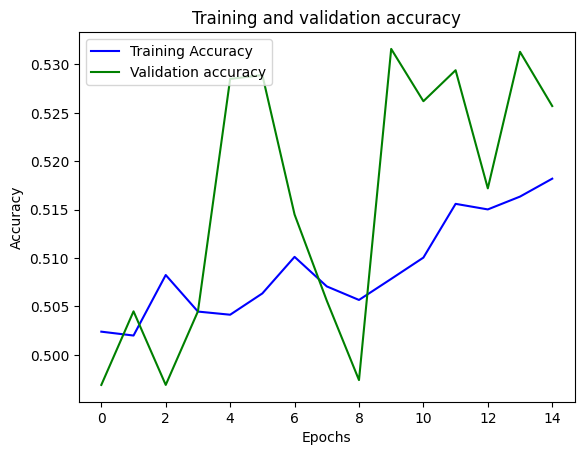

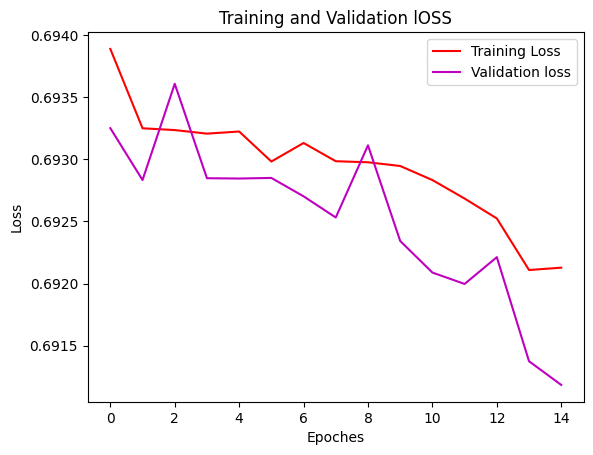

In [156]:
plt_acc_graph(history_w2v)
plt_loss_graph(history_w2v)

### 8. Bert


In [157]:
from transformers import BertTokenizer , TFBertModel , TFBertForSequenceClassification

In [167]:
def preprocess_text(text_list):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encoded = tokenizer(text_list , padding = True,truncation=True , return_tensors ='tf')
    return encoded


In [173]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf

def build_model():
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    
    # Use TensorFlow's Adam optimizer directly
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    
    # Specify SparseCategoricalCrossentropy loss with from_logits=True
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    # Compile the model with the optimizer, loss, and accuracy metrics
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [161]:
def train_model(model , X_train , y_train , X_val , y_val , epochs = 5):
    X_train_input = {
        'input_ids': np.array(X_train['input_ids']),
        'attention_mask':np.array(X_val['attention_mask'])
        
    }
    
    history = model.fit(
        X_train_input , y_train,
        validation_data = (X_val_input , y_val),
        epochs = epochs,
        batch_size = 32
    )
    
    return history

In [162]:
def evaluate_model(model , X_test , y_test):
    y_pred = model.predict(X_test)
    y_pred = tf.argmax(y_pred['logits'], axis = 1)
    print(classification_report(y_test , y_pred))
    
    return y_pred.numpy()

In [171]:
# Splitting the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_dl['review'], df_dl['sentiment'], test_size=0.2)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# Preprocess the text data
encoded_train = preprocess_text(X_train.tolist())
encoded_val = preprocess_text(X_val.tolist())
encoded_test = preprocess_text(X_test.tolist())

In [ ]:
model = build_model()
model.summary()

In [ ]:
history_bert = train_model(model,encoded_train , y_train,encoded_val ,y_val)

In [ ]:
plt_acc_graph(history_bert)
plt_loss_graph(history_bert)

### 9.Summary

* In this notebook I have not run BERT and SVM as both of them were taking a long time for execution.

### Analysis

* We can see from this notebooks data that TF-IDF approach for all the ML algorithms has performed well in terms of accuracy in comparison to with BOW(bag of words). This can attribute to :

* **Handling common words**  : In sentiment analysis , certain words might frequently occur accross some classes , making it challenging for BOW to differentiate sentiments meaning and context . TF-IDF balances the significance of words, reducing bias towards frequent , but less informative words.

* **Term Weighting** : TF-IDF assign higher weights to terms that are frequent in document but rare across the corpus , emphasizing their importance in discriminating between classes.

* **Semantic Understanding** : TF-IDF gives semantic relevance to terms , allowing model to give more weights to words having more relevance with respect to the context. 

* **Dimentionality Reduction** : TF-IDF reduces the impact of frequently occuring words(stop words) by assigning lower weights to them. Dimentionality reduction also helps in focusing on the essential discriminating features. 

* **Normalization** : TF-IDF nomalizes the importance of words across documents, making the represention more robust and reducing the impact of document length on the analysis

* **Reducing Noise** : TF-IDF can reduce the noise in the data by diminishing the influence of common words and increasing the impact of more rare words used in the reviews potentially imporving the models ability to generalize the unseen data.  

* While training the deep learning model we encounted with the problem of overfitting which was later encountered by L2 regularization and early stopping.

* Both Stochastic Gradient descent and Logistic regression did extremely well in classification task providing accuracy of ~ 87%


* Word2vec didnt prove effective.